In [24]:
from sklearn import linear_model
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

### Time Series Analysis

In [4]:
df_deploy = pd.read_csv("./deploymentTime.csv")

In [5]:
len(df_deploy)

1244

In [75]:
df_deploy.head()

,epoch,ts,cpu,gpu1,gpu2
0,1578450656,2020-01-07 18:30:56,6.741983,7.174839,9.463056
1,1578450748,2020-01-07 18:32:28,6.433090,6.586499,9.773075
2,1578450848,2020-01-07 18:34:08,6.406432,6.436442,18.477036
3,1578450976,2020-01-07 18:36:16,6.458927,6.437795,45.621880
4,1578451082,2020-01-07 18:38:02,6.414540,6.433022,24.498318


In [340]:
def histogram(runtime, bins):
    df_deploy[runtime].hist(bins=bins)

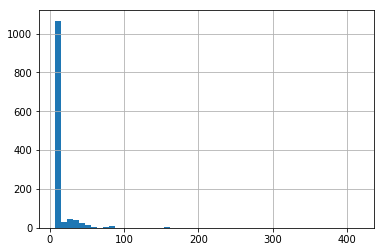

In [343]:
histogram("cpu", 50)

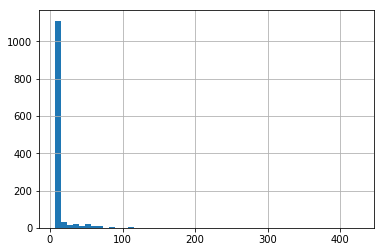

In [344]:
histogram("gpu1", 50)

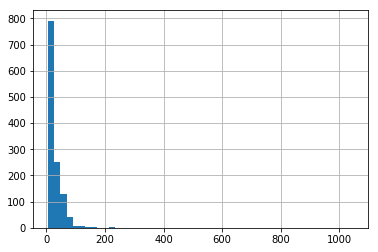

In [345]:
histogram("gpu2", 50)

In [154]:
def time_series(runtime):
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111)
    ax.plot(df_deploy['epoch'], df_deploy[runtime])
    ax.grid()

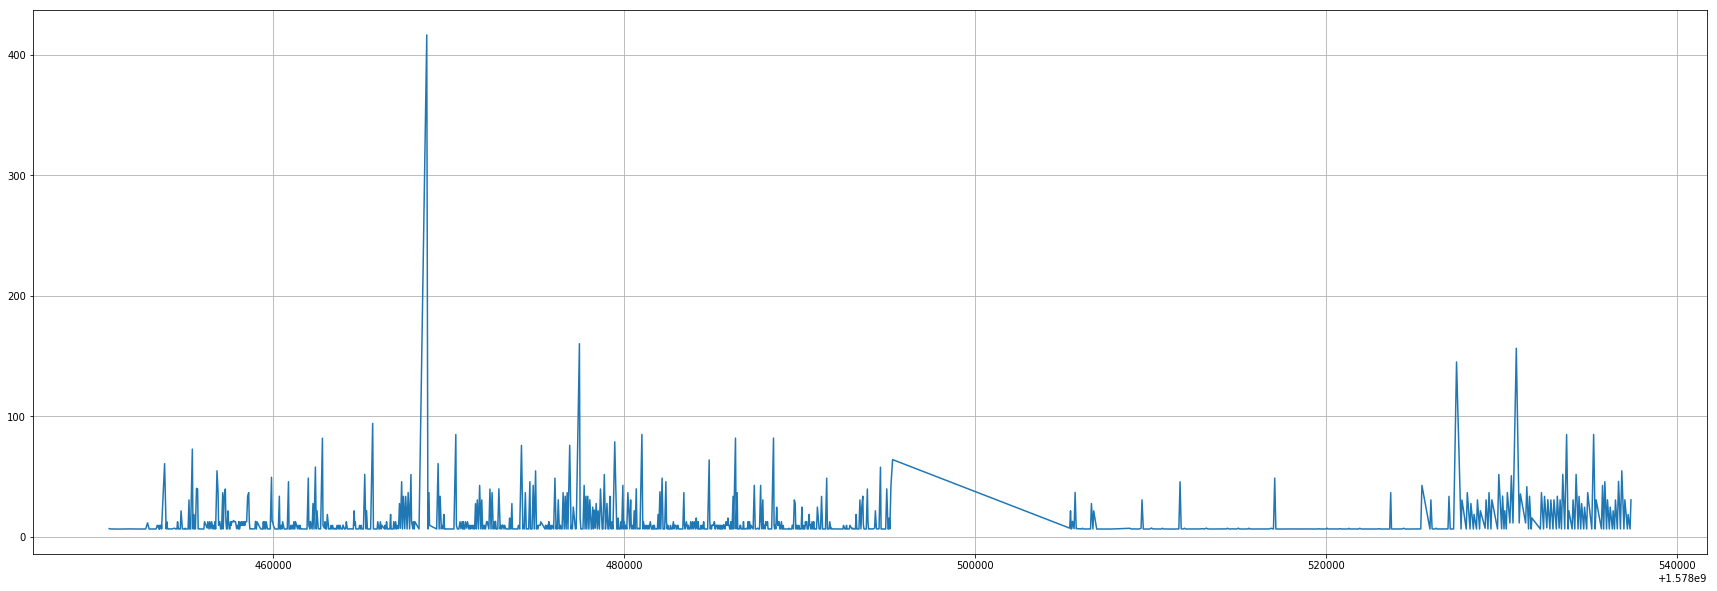

In [116]:
time_series('cpu')

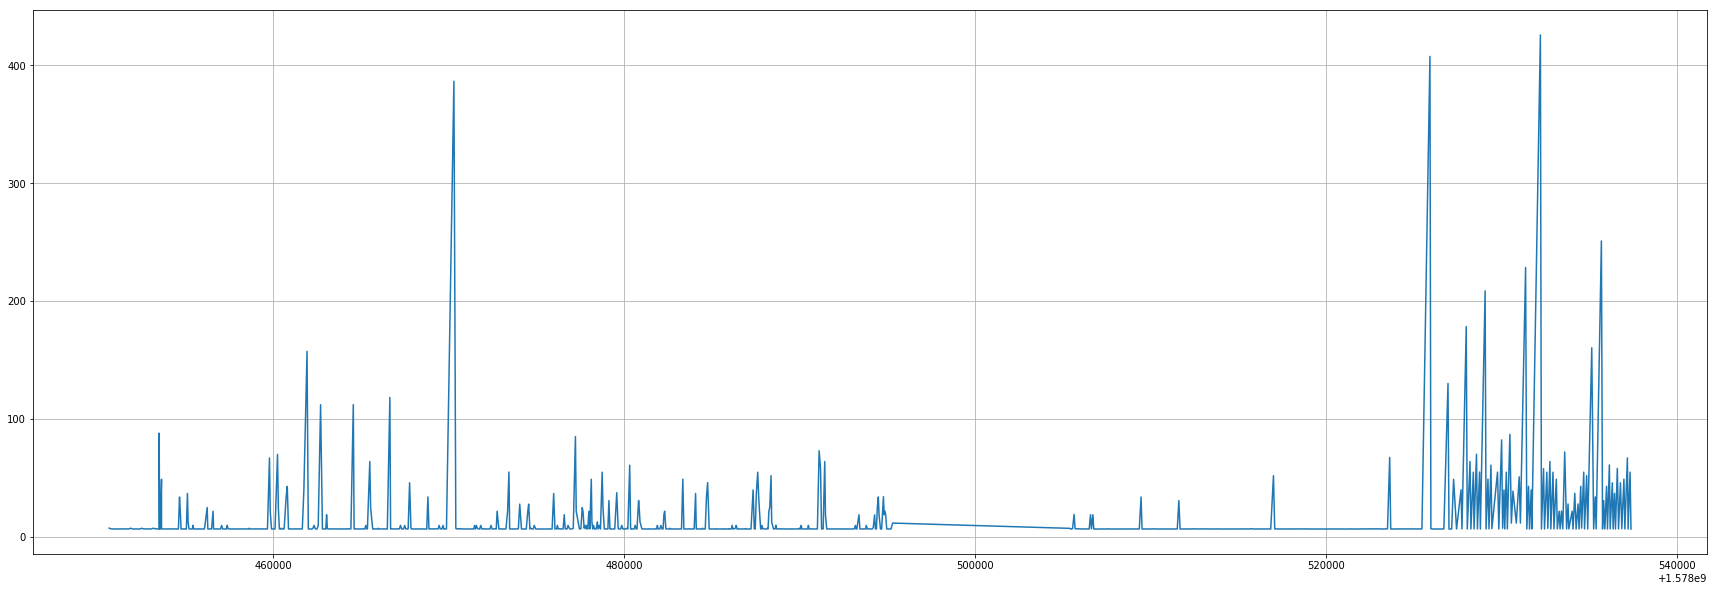

In [117]:
time_series('gpu1')

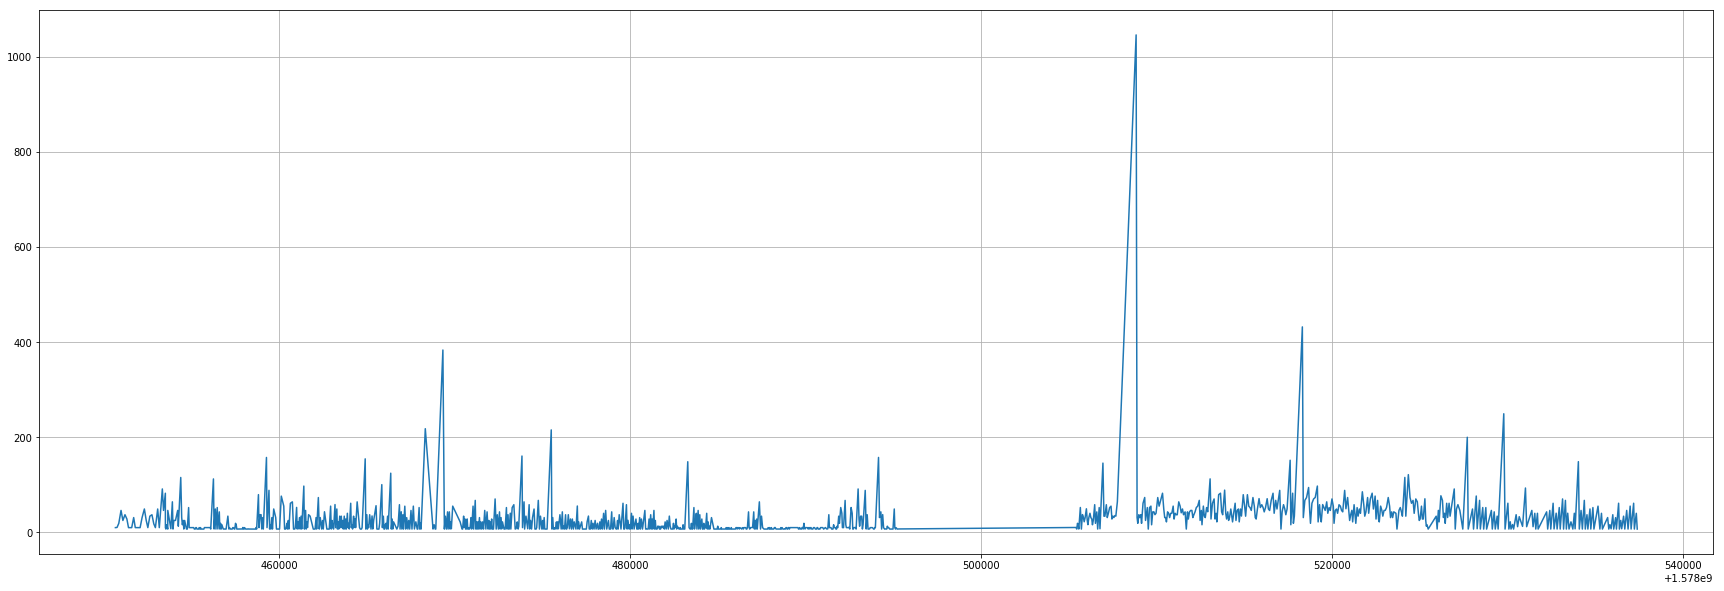

In [118]:
time_series('gpu2')

In [178]:
def autocorrelation(runtime):
    plt.figure(figsize=[20,20])
    df_runtime_deploy = df_deploy[['ts', runtime]].set_index('ts')[runtime]
    autocorrelation_plot(df_runtime_deploy)
    plt.figure(figsize=[30,10])
    plot_acf(df_runtime_deploy, lags=30)

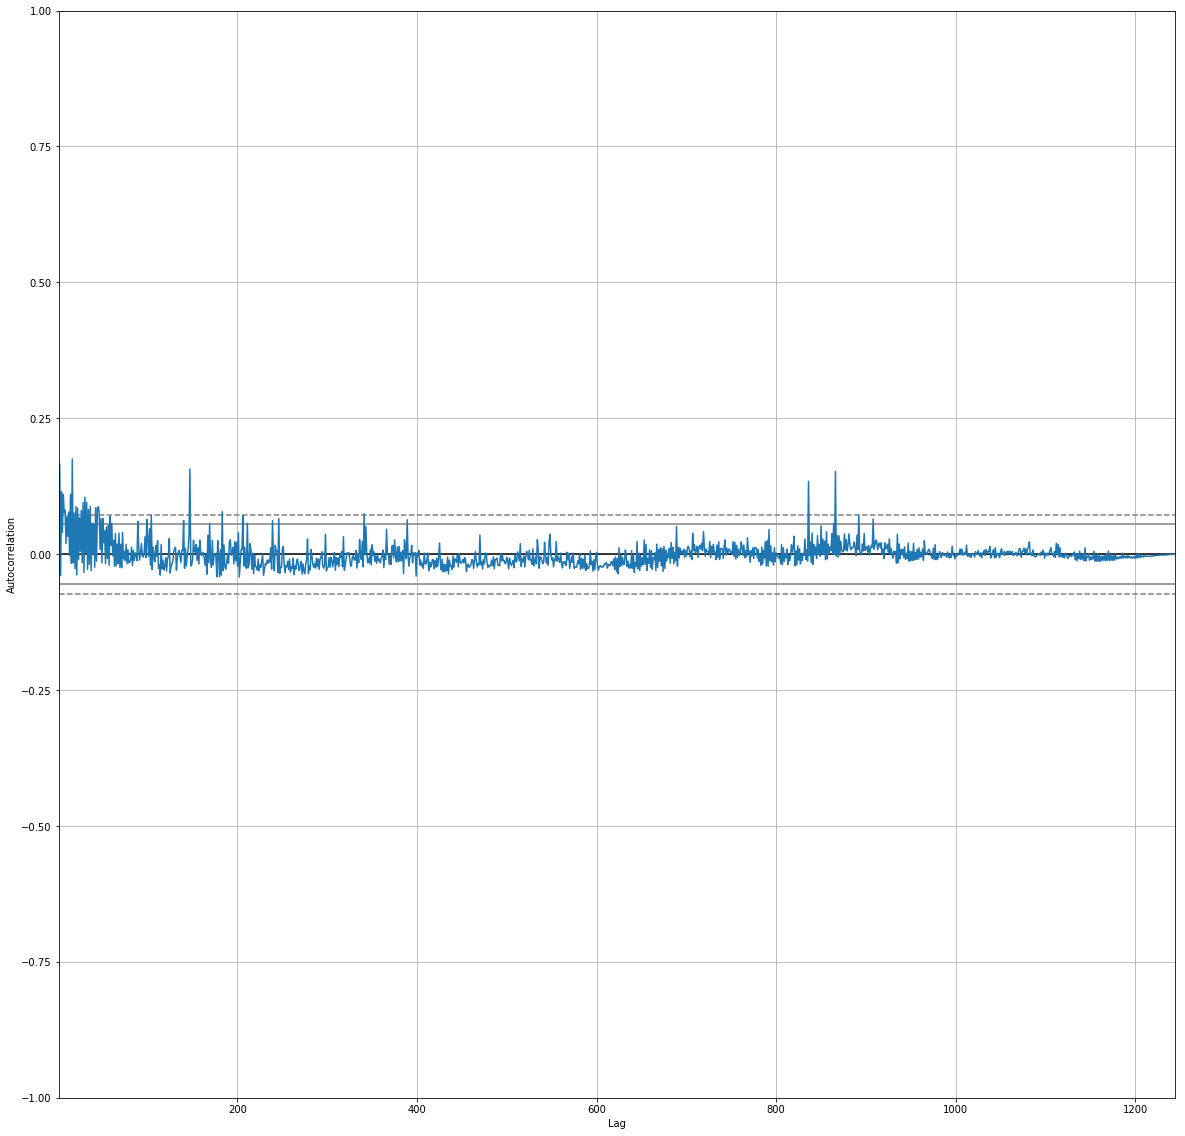

<Figure size 2160x720 with 0 Axes>

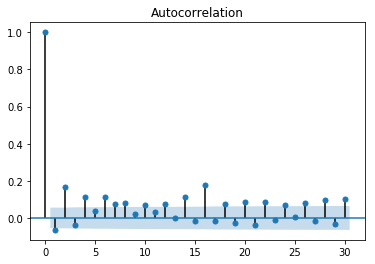

In [179]:
autocorrelation('cpu')

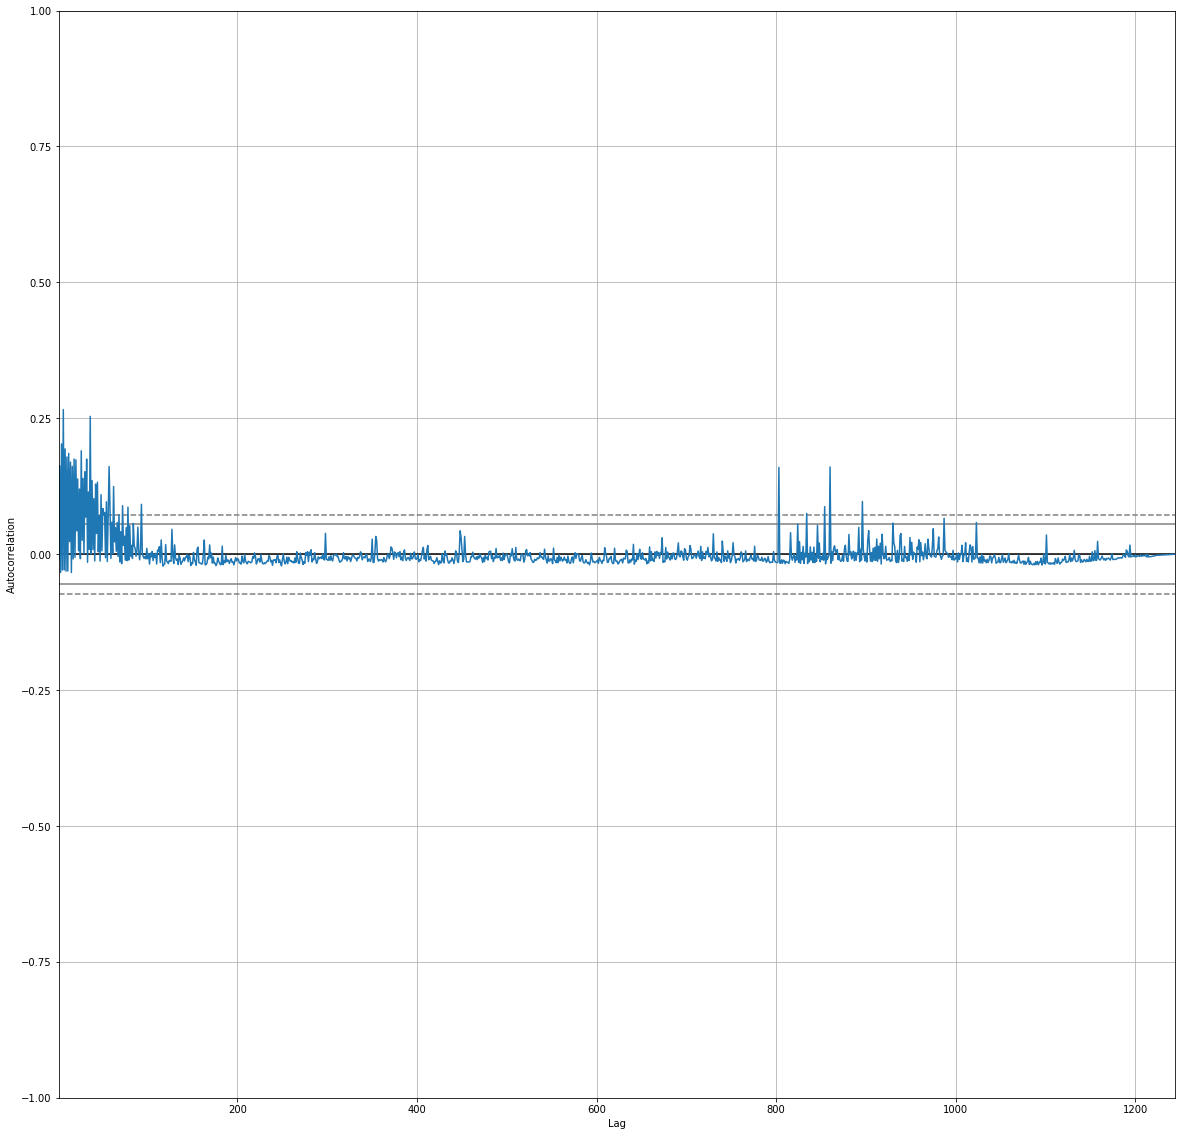

<Figure size 2160x720 with 0 Axes>

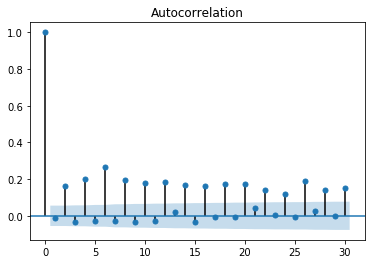

In [181]:
autocorrelation('gpu1')


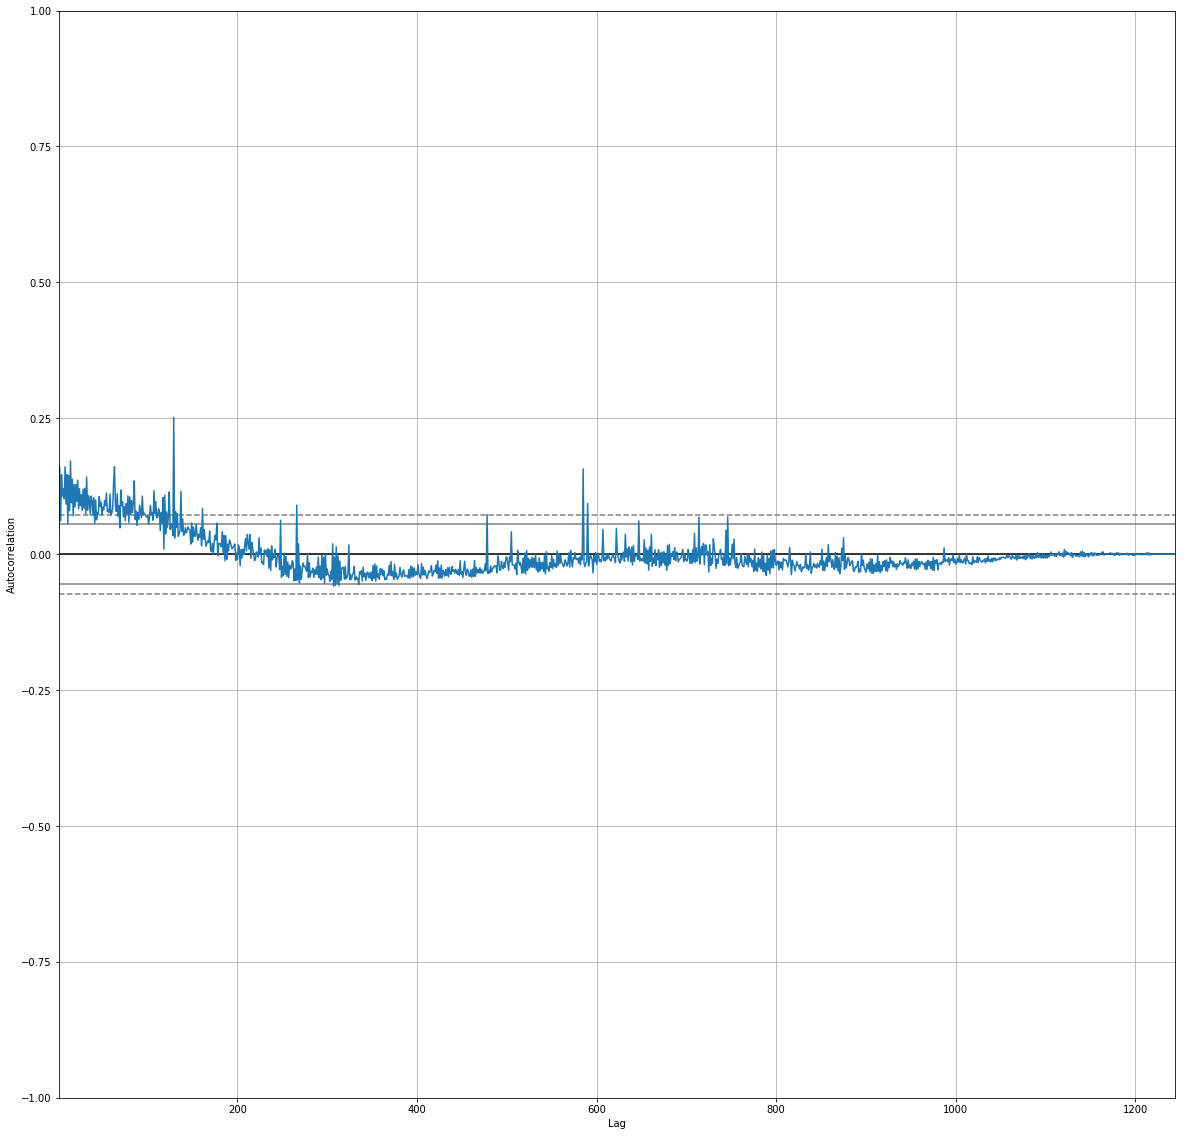

<Figure size 2160x720 with 0 Axes>

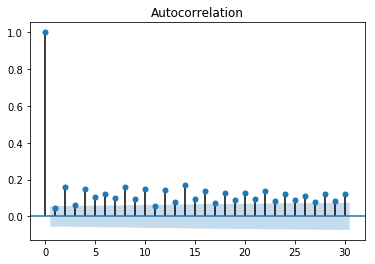

In [180]:
autocorrelation('gpu2')

In [314]:
def autoregress(runtime, test_percent):
    df_runtime_deploy = df_deploy[['ts', runtime]].set_index('ts')[runtime]
    # split dataset
    X = df_runtime_deploy.values
    test_len = round(len(X) * test_percent)
    train, test = X[1:len(X)-test_len], X[len(X)-test_len:]
    # train autoregression
    model = AR(train)
    model_fit = model.fit()
    # The optimal lag is selectd from training process
    window = model_fit.k_ar
    print ("Window size : ", window)
    coef = model_fit.params
    # History is the last lag observations
    history = train[len(train)-window:]
    # convert from ndarray to list
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)

        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)

        # history is dynamically updated.
        history.append(obs)
        # print('predicted=%f, expected=%f' % (yhat, obs))
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    print('Test MSE: %.3f' % mse)
    print ('Test RMSE: %.3f' % mse**(0.5))
    print('Test MAE: %.3f' % mae)
    # plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

Window size :  15
Test MSE: 396.434
Test RMSE: 19.911
Test MAE: 8.977


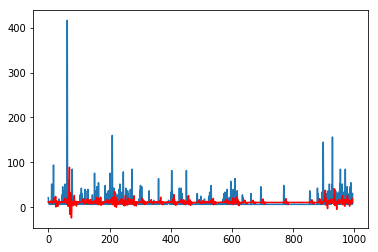

In [327]:
autoregress('cpu', 0.8)

Window size :  15
Test MSE: 888.815
Test RMSE: 29.813
Test MAE: 9.605


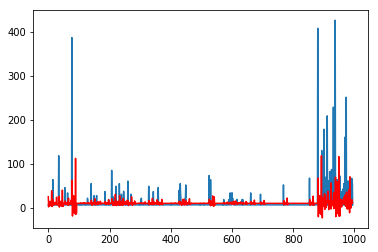

In [326]:
autoregress('gpu1', 0.8)

Window size :  15
Test MSE: 2143.119
Test RMSE: 46.294
Test MAE: 17.918


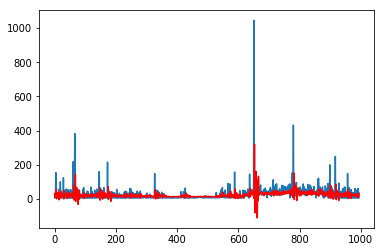

In [334]:
autoregress('gpu2', 0.8)

In [115]:
df_deploy['gpu1'].max()

425.82247925

### Task Latency Analysis

In [190]:
def error_metrics(runtime):
    df_logtime = pd.read_csv("./logTime.csv")
    df_runtime_logtime = df_logtime[df_logtime['runtime']==runtime]
    df_pe = pd.DataFrame({"epoch": df_runtime_logtime['epoch'], "image_num": df_runtime_logtime['image_num'], "runtime": df_runtime_logtime['runtime'],
                       "pe_total" : (df_runtime_logtime['act_total'] - df_runtime_logtime['pred_total'])/df_runtime_logtime['act_total'], 
                       "pe_transfer" : (df_runtime_logtime['act_transfer'] - df_runtime_logtime['pred_transfer'])/df_runtime_logtime['act_transfer'], 
                       "pe_deploy" : (df_runtime_logtime['act_deploy'] - df_runtime_logtime['pred_deploy'])/df_runtime_logtime['act_deploy'],
                       "pe_proc" : (df_runtime_logtime['act_proc'] - df_runtime_logtime['pred_proc'])/df_runtime_logtime['act_proc']})
    df_mpe = pd.DataFrame({"mpe_total": df_pe["pe_total"].mean(), "mpe_transfer": df_pe['pe_transfer'].mean(), 
                       "mpe_deploy": df_pe["pe_deploy"].mean(), "mpe_proc": df_pe["pe_proc"].mean()}, index=[0])
    print (runtime + " Mean Percentage Error")
    print (df_mpe)
    df_mae = pd.DataFrame({'mae_total': abs(df_runtime_logtime["act_total"] - df_runtime_logtime["pred_total"]).mean(), 
                       'mae_transfer': abs(df_runtime_logtime["act_transfer"] - df_runtime_logtime["pred_transfer"]).mean(), 
                       "mae_deploy": abs(df_runtime_logtime["act_deploy"] - df_runtime_logtime["pred_deploy"]).mean(), 
                       "mae_proc": abs(df_runtime_logtime["act_proc"] - df_runtime_logtime["pred_proc"]).mean()}, index=[0])
    print (runtime + " Mean Absolute Error")
    print (df_mae)
    df_mse = pd.DataFrame({"mse_total": ((df_runtime_logtime["act_total"] - df_runtime_logtime["pred_total"])**2).mean(), 
                       "mse_transfer": ((df_runtime_logtime["act_transfer"] - df_runtime_logtime["pred_transfer"])**2).mean(),
                       "mse_deploy": ((df_runtime_logtime["act_deploy"] - df_runtime_logtime["pred_deploy"])**2).mean(), 
                       "mse_proc": ((df_runtime_logtime["act_proc"] - df_runtime_logtime["pred_proc"])**2).mean()}, index=[0])
    print (runtime + " Mean Squared Error")
    print (df_mse)

In [199]:
error_metrics("gpu2")

gpu2 Mean Percentage Error
   mpe_total  mpe_transfer  mpe_deploy  mpe_proc
0  -0.869685 -1.014581e-13   -2.982545 -0.006546
gpu2 Mean Absolute Error
   mae_total  mae_transfer  mae_deploy  mae_proc
0  22.944981  2.503981e-11   19.481822  1.681438
gpu2 Mean Squared Error
    mse_total  mse_transfer  mse_deploy   mse_proc
0  544.831195  8.551769e-22   391.84741  19.591551


In [6]:
df_logtime.head()

,epoch,image_num,runtime,pred_total,pred_transfer,pred_deploy,pred_proc,act_total,act_transfer,act_deploy,act_proc
0,1578450715,33,edge,94.537888,1.885893,0.000000,92.651993,70.275116,1.885893,0.000000,70.275116
1,1578450743,10,edge,21.790455,0.494965,0.000000,21.295490,22.239460,0.494965,0.000000,22.239460
2,1578450863,33,cpu,67.301781,1.633384,6.741983,58.926411,86.213676,1.633384,33.590122,52.623554
3,1578450904,10,cpu,22.968664,0.494965,6.527168,15.946531,18.691763,0.494965,6.470972,12.220791
4,1578451112,33,gpu1,47.325912,1.633384,6.732593,38.959934,104.747849,1.633384,51.749138,52.998711


In [62]:
df_pe = pd.DataFrame({"epoch": df_logtime['epoch'], "image_num": df_logtime['image_num'], "runtime": df_logtime['runtime'],
                       "pe_total" : (df_logtime['act_total'] - df_logtime['pred_total'])/df_logtime['act_total'], 
                       "pe_transfer" : (df_logtime['act_transfer'] - df_logtime['pred_transfer'])/df_logtime['act_transfer'], 
                       "pe_deploy" : (df_logtime['act_deploy'] - df_logtime['pred_deploy'])/df_logtime['act_deploy'],
                       "pe_proc" : (df_logtime['act_proc'] - df_logtime['pred_proc'])/df_logtime['act_proc']})

### Mean Percentage Error

In [64]:
df_mpe = pd.DataFrame({"mpe_total": df_pe["pe_total"].mean(), "mpe_transfer": df_pe['pe_transfer'].mean(), 
                       "mpe_deploy": df_pe["pe_deploy"].mean(), "mpe_proc": df_pe["pe_proc"].mean()}, index=[0])

In [66]:
# Mean Percentage Error
df_mpe

,mpe_total,mpe_transfer,mpe_deploy,mpe_proc
0,-0.483446,5.316152e-13,-1.964719,-0.005967


### Mean Absolute Error

In [51]:
df_mae = pd.DataFrame({'mae_total': abs(df_logtime["act_total"] - df_logtime["pred_total"]).mean(), 
                       'mae_transfer': abs(df_logtime["act_transfer"] - df_logtime["pred_transfer"]).mean(), 
                       "mae_deploy": abs(df_logtime["act_deploy"] - df_logtime["pred_deploy"]).mean(), 
                       "mae_proc": abs(df_logtime["act_proc"] - df_logtime["pred_proc"]).mean()}, index=[0])

In [52]:
df_mae

,mae_total,mae_transfer,mae_deploy,mae_proc
0,13.899921,2.162601e-11,10.845259,1.781663


### Mean Square Error

In [58]:
df_mse = pd.DataFrame({"mse_total": ((df_logtime["act_total"] - df_logtime["pred_total"])**2).mean(), 
                       "mse_transfer": ((df_logtime["act_transfer"] - df_logtime["pred_transfer"])**2).mean(),
                       "mse_deploy": ((df_logtime["act_deploy"] - df_logtime["pred_deploy"])**2).mean(), 
                       "mse_proc": ((df_logtime["act_proc"] - df_logtime["pred_proc"])**2).mean()}, index=[0])

In [59]:
df_mse

,mse_total,mse_transfer,mse_deploy,mse_proc
0,316.139132,8.088897e-22,224.443791,20.383685


### Autoregression model VS Average VS Median

### Average Window size [1 - 100]

In [9]:
df = pd.DataFrame({"cpu": np.array([1,2,3,4,5,6])})
method = "average"
df = df['cpu']
# Initialize two arrays for MSE and MAE 
mse_arr = []
mae_arr = []
for window_size in range(2, 3):

    length = len(df) - window_size
    total_squared_error = 0
    total_abs_error = 0
    for idx in range(0, length):
        if (method == "average"):
            pred = df[idx:idx + window_size].mean()
        else:
            pred = df[idx:idx + window_size].median()
        total_squared_error += (pred - df[idx + window_size])**2
        # print("tse : ", (pred - df[idx + window_size])**2)
        total_abs_error += abs(pred - df[idx + window_size])
        print("tae : ", total_abs_error)

    mse_arr.append(total_squared_error / length)
    mae_arr.append(total_abs_error / length)


tae :  1.5
tae :  3.0
tae :  4.5
tae :  6.0


In [15]:
def slide(runtime="cpu", max_window_size=100, method="med"):
    df_runtime_deploy = df_deploy[runtime]
    # Initialize two arrays for MSE and MAE 
    rmse_arr = []
    mae_arr = []
    for window_size in range(1, max_window_size + 1):
        length = len(df_runtime_deploy) - window_size
        total_squared_error = 0
        total_abs_error = 0
        for idx in range(0, length):
            if (method == "average"):
                pred = df_runtime_deploy[idx:idx + window_size].mean()
            else:
                pred = df_runtime_deploy[idx:idx + window_size].median()
                
            total_squared_error += (pred - df_runtime_deploy[idx + window_size])**2
            total_abs_error += abs(pred - df_runtime_deploy[idx + window_size])

        rmse_arr.append((total_squared_error / length)**(0.5))
        mae_arr.append(total_abs_error / length)

    print ("Minimum RMSE : {0} at window size {1}".format(min(rmse_arr), rmse_arr.index(min(rmse_arr))))
    print ("Minimum MAE : {0} at window size {1}".format(min(mae_arr), mae_arr.index(min(mae_arr))))
    
    fig = plt.figure(figsize=[20,10])
    # fig.suptitle("Erorr Analysis Runtime: {0} Method: {1}".format(runtime, method))
    ax = fig.add_subplot(121)
    ax.plot(range(1, 101), rmse_arr, 'r')
    ax.grid()    
    ax.set_xlabel("Window Size", fontsize=16)
    ax.set_ylabel("Root Mean Squared Error", fontsize=16)
    ax = fig.add_subplot(122)
    ax.plot(range(1, 101), mae_arr, 'b')
    ax.grid()    
    ax.set_xlabel("Window Size", fontsize=16)
    ax.set_ylabel("Mean Absolute Error", fontsize=16)    

    return mse_arr, mae_arr 

In [37]:
def slide2(runtime="cpu", max_window_size=100):
    df_runtime_deploy = df_deploy[runtime]
    # Initialize two arrays for MSE and MAE 
    mae_arr_avg = []
    mae_arr_median = []
    for window_size in range(1, max_window_size + 1):
        length = len(df_runtime_deploy) - window_size
        total_abs_error_median = 0
        total_abs_error_avg = 0
        for idx in range(0, length):
            pred_median = df_runtime_deploy[idx:idx + window_size].median()
            pred_avg = df_runtime_deploy[idx:idx + window_size].mean()
                
            total_abs_error_median += abs(pred_median - df_runtime_deploy[idx + window_size])
            total_abs_error_avg += abs(pred_avg - df_runtime_deploy[idx + window_size])

        mae_arr_median.append(total_abs_error_median / length)
        mae_arr_avg.append(total_abs_error_avg / length)

    print ("Minimum MAE Median : {0} at window size {1}".format(min(mae_arr_median), mae_arr_median.index(min(mae_arr_median))))
    print ("Minimum MAE Avg : {0} at window size {1}".format(min(mae_arr_avg), mae_arr_avg.index(min(mae_arr_avg))))
    
    fig = plt.figure(figsize=[20,10])
    # fig.suptitle("Erorr Analysis Runtime: {0} Method: {1}".format(runtime, method))
    ax = fig.add_subplot(121)
    ax.plot(range(1, 101), mae_arr_avg, 'r', label="Average Sliding Window")
    ax.grid()    
    ax.set_xlabel("Window Size", fontsize=24)
    ax.set_ylabel("Mean Absolute Error", fontsize=24)
    ax.legend(fontsize=24)
    ax = fig.add_subplot(122)
    ax.plot(range(1, 101), mae_arr_median, 'b', label="Median Sliding Window")
    ax.grid()    
    ax.set_xlabel("Window Size", fontsize=24)
    ax.set_ylabel("Mean Absolute Error", fontsize=24)    
    ax.legend(fontsize=24)
    return mse_arr, mae_arr 

Minimum MAE Median : 5.668677799613826 at window size 31
Minimum MAE Avg : 8.00650630766389 at window size 31


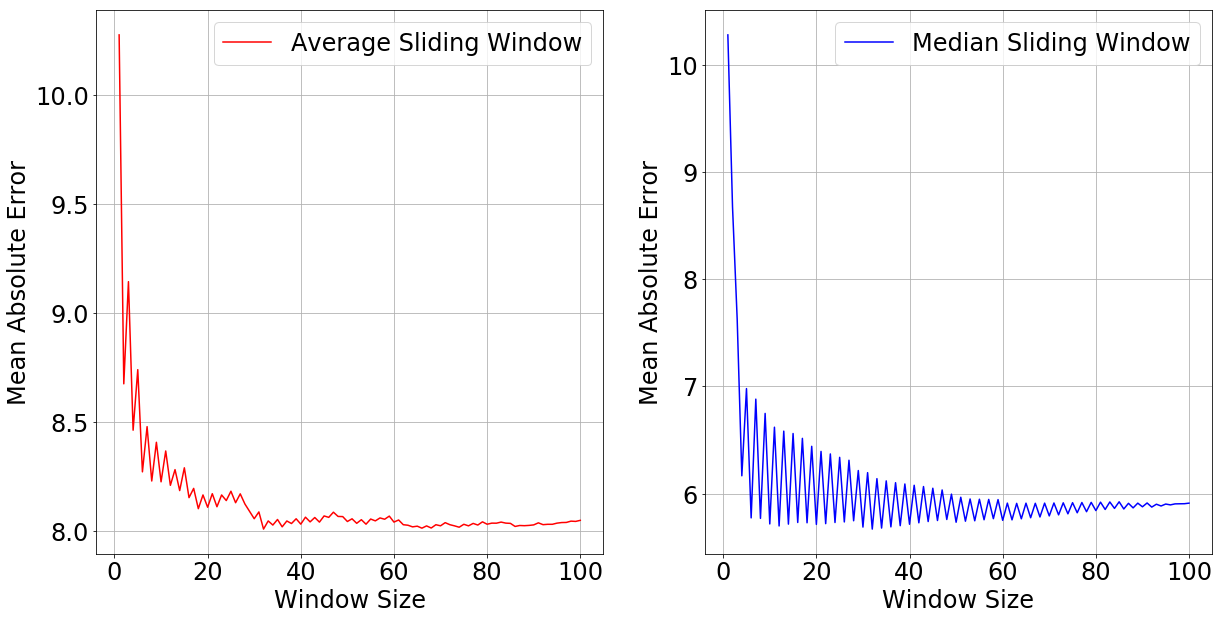

In [38]:
gpu1_med_rmse_arr, gpu1_med_mae_arr = slide2("gpu1")

Minimum RMSE : 18.12260419084064 at window size 33
Minimum MAE : 7.714686132203859 at window size 33


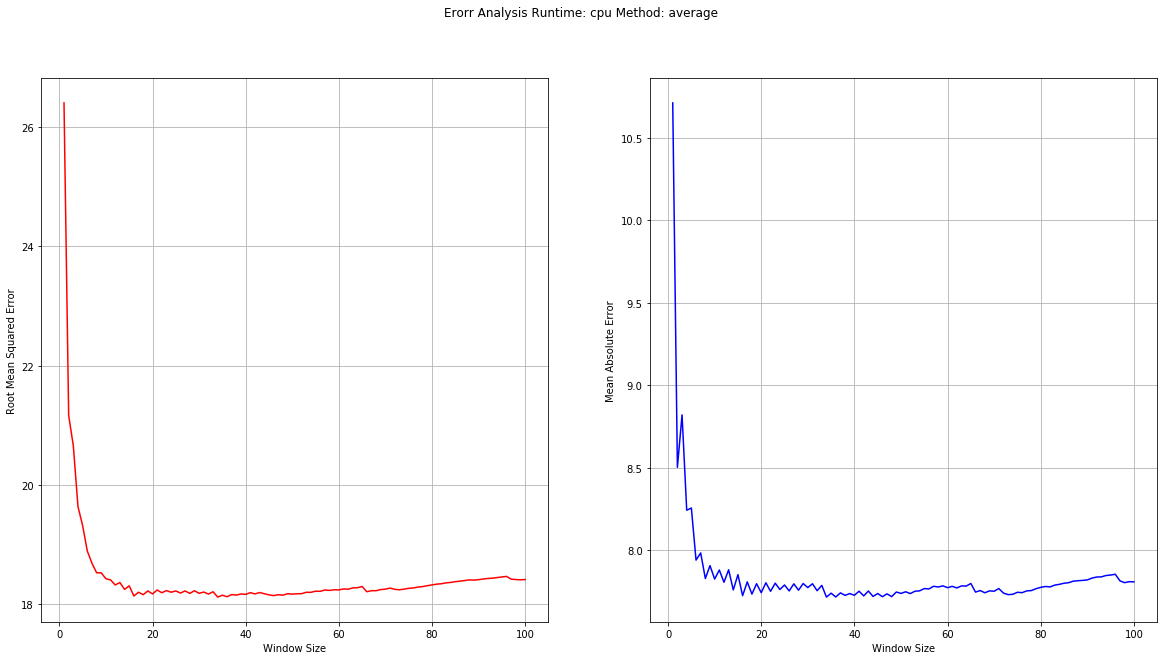

In [304]:
cpu_aver_rmse_arr, cpu_aver_mae_arr = slide("cpu", method="average")

Minimum RMSE : 18.435716171841108 at window size 5
Minimum MAE : 5.960541363079988 at window size 13


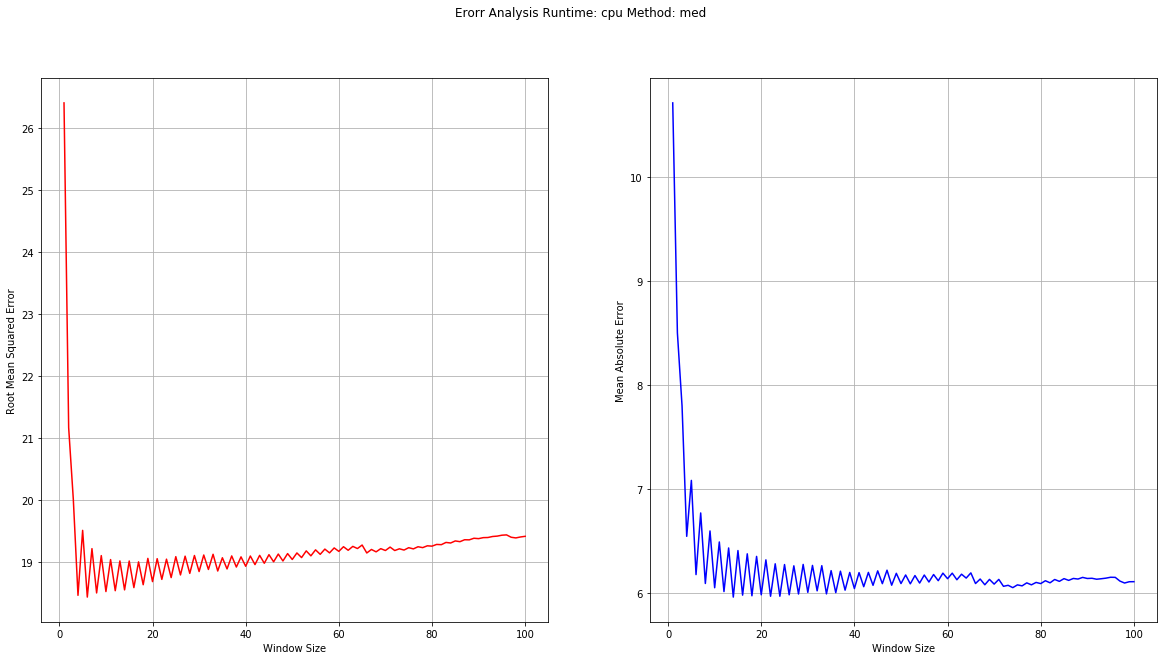

In [305]:
cpu_med_rmse_arr, cpu_med_mae_arr = slide("cpu", method="med")

Minimum RMSE : 26.024279844310733 at window size 35
Minimum MAE : 8.00650630766389 at window size 31


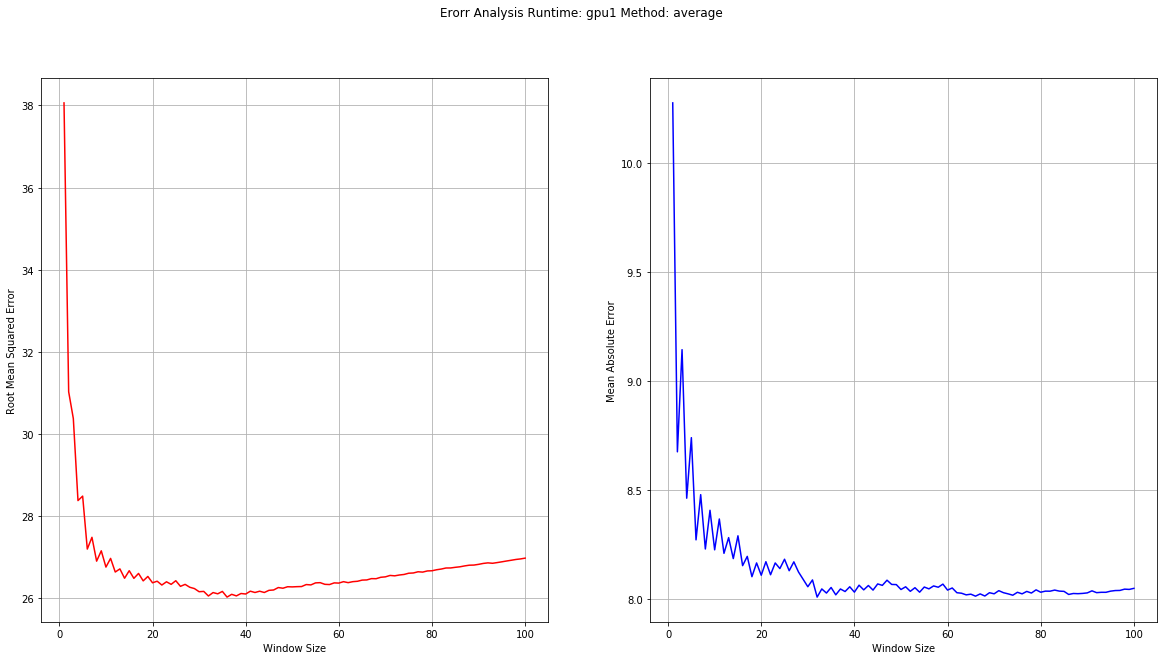

In [306]:
gpu1_aver_rmse_arr, gpu1_aver_mae_arr = slide("gpu1", method="average")

Minimum RMSE : 26.216638357934237 at window size 3
Minimum MAE : 5.668677799613826 at window size 31


NameError: name 'mse_arr' is not defined

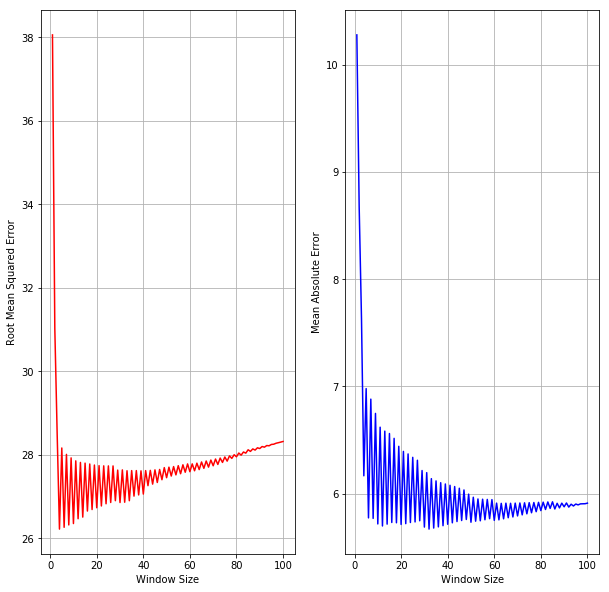

In [7]:
gpu1_med_rmse_arr, gpu1_med_mae_arr = slide("gpu1", method="median")

Minimum RMSE : 40.66116618942007 at window size 31
Minimum MAE : 16.52487348854968 at window size 91


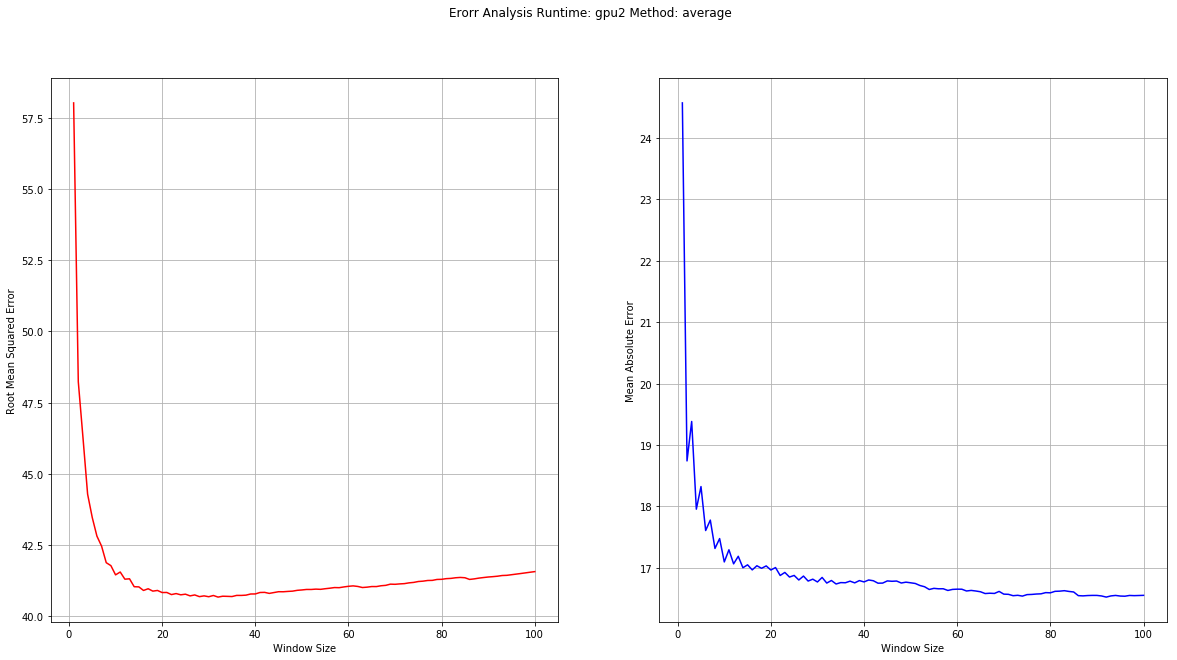

In [308]:
gpu2_aver_rmse_arr, gpu2_aver_mae_arr = slide("gpu2", method="average")

Minimum RMSE : 41.005950517526905 at window size 7
Minimum MAE : 14.480641267991823 at window size 27


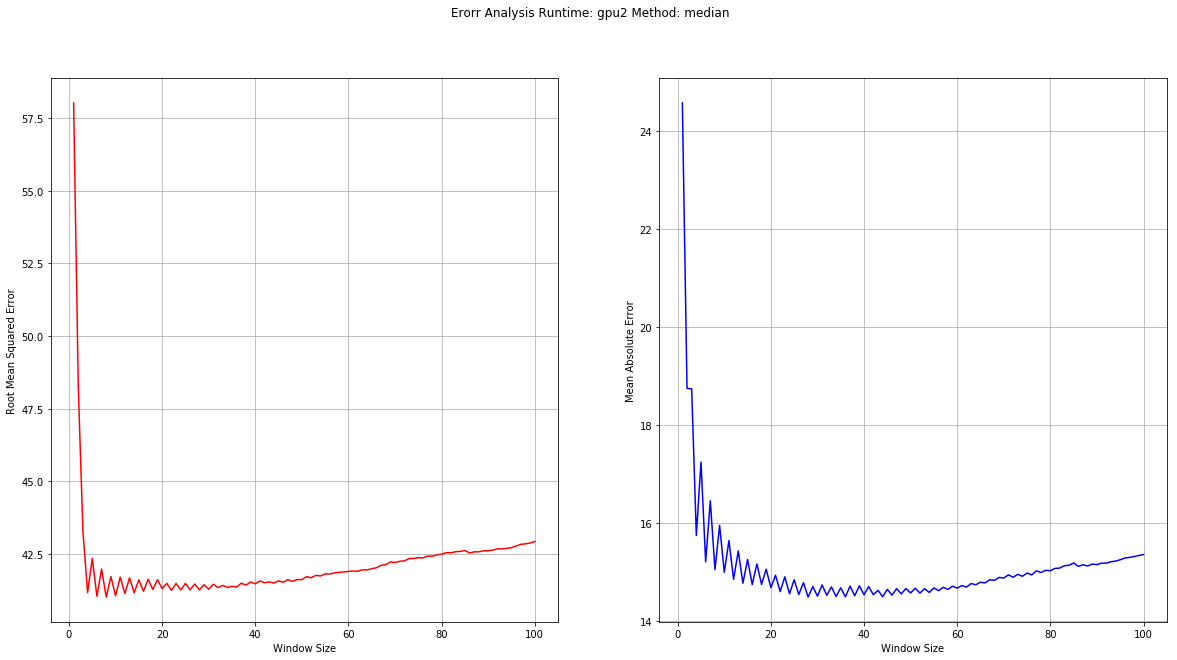

In [309]:
gpu2_med_rmse_arr, gpu2_med_mae_arr = slide("gpu2", method="median")

In [237]:
def plot(arr):
    print("ABC")
    fig = plt.figure(figsize=[20,10])
    ax = fig.add_subplot(121)
    ax.plot(range(1, 101), mse_arr, 'r')
    ax.grid()    
    ax.set_xlabel("Window Size")
    ax.set_ylabel("Mean Square Error")
    ax = fig.add_subplot(122)
    ax.plot(range(1, 101), mae_arr, 'b')
    ax.grid()    
    ax.set_xlabel("Window Size")
    ax.set_ylabel("Mean Absolute Error")

#### Comparison

CPU - Average

Minimum RMSE : 18.12260419084064 at window size 33
Minimum MAE : 7.714686132203859 at window size 33

CPU - Median

Minimum RMSE : 18.435716171841108 at window size 5
Minimum MAE : 5.960541363079988 at window size 13

GPU1 - Average

Minimum RMSE : 26.024279844310733 at window size 35
Minimum MAE : 8.00650630766389 at window size 31

GPU1 - Median

Minimum RMSE : 26.216638357934237 at window size 3
Minimum MAE : 5.668677799613826 at window size 31

GPU2 - Average 

Minimum RMSE : 40.66116618942007 at window size 31
Minimum MAE : 16.52487348854968 at window size 91

GPU2 - Median

Minimum RMSE : 41.005950517526905 at window size 7
Minimum MAE : 14.480641267991823 at window size 27

AR CPU

Window size :  15
Test MSE: 396.434
Test RMSE: 19.911
Test MAE: 8.977

AR GPU1

Window size :  15
Test MSE: 888.815
Test RMSE: 29.813
Test MAE: 9.605

AR GPU2

Window size :  15
Test MSE: 2143.119
Test RMSE: 46.294
Test MAE: 17.918

